In [23]:
# Importing necessary libraries for data manipulation, model training, and evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
from scipy.stats import uniform, randint

In [24]:
# loading the dataset
data = pd.read_csv('C:\\Users\\Kamlesh P Panchal\\Documents\\Infosys Internship\\submission\\df_cleaned.csv')
data

,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,...,Item_Identifier,Outlet_Identifier,Outlet_Establishment_Year,Item_Outlet_Sales,Outlet_age,sales_per_mrp,Item_Weight_zscore,Item_Visibility_zscore,Item_MRP_zscore,Item_Outlet_Sales_zscore
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2879.598286,2348.354635,1999,3735.1380,25,14.951963,0.828359,0.970675,1.747351,0.910548
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1920.354050,1995.498739,2009,443.4228,15,9.186454,1.625269,0.908058,1.488936,1.018381
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2030.685308,2348.354635,1999,2097.2700,25,14.809346,1.104972,0.956861,0.010040,0.049235
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2347.410648,339.351662,1998,732.3800,26,4.021967,1.505785,1.281683,0.660011,0.849053
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1879.152033,2298.995256,1987,994.7052,37,18.467868,0.915595,1.281683,1.399138,0.695332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2424.628001,2298.995256,1987,2778.3834,37,12.951520,1.402464,0.181183,1.180714,0.349894
8519,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2271.350452,2192.384798,2002,549.2850,22,5.078589,1.045270,0.371132,0.527270,0.956346
8520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1991.431370,2438.841866,2004,1193.1136,20,14.016447,0.521856,0.599749,0.897155,0.579066
8521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2158.829654,1995.498739,2009,1845.5976,15,17.895281,1.321123,1.532790,0.607941,0.196713


In [25]:
# Separating features (X) and target variable (y)
X = data.drop('Item_Outlet_Sales', axis=1)  # Features
y = data['Item_Outlet_Sales']  # Target

In [26]:
# Splitting the data into training and test sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Feature Importance Plot (RandomForestRegressor)

In [27]:
# Using RandomForestRegressor to determine feature importance
feature_selector = RandomForestRegressor(n_estimators=100, random_state=42)
feature_selector.fit(x_train, y_train)

# Selecting the top 10 important features based on feature importance scores
feature_importances = pd.Series(feature_selector.feature_importances_, index=X.columns)
top_features = feature_importances.nlargest(10).index
X_top = X[top_features]

x_train, x_test = x_train[top_features], x_test[top_features]

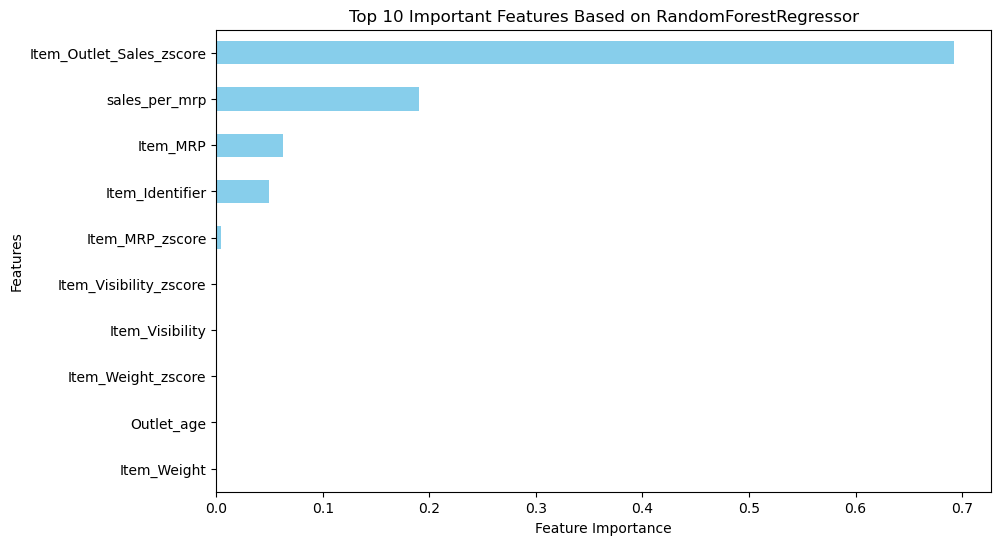

In [28]:
import matplotlib.pyplot as plt

# Plotting feature importances for the top 10 important features
plt.figure(figsize=(10, 6))
top_features_importances = feature_importances.nlargest(10)  # Get the top 10 feature importances
top_features_importances.plot(kind='barh', color='skyblue')

# Customize the plot
plt.title("Top 10 Important Features Based on RandomForestRegressor")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()


In [29]:
# Defining multiple regression models for evaluation
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression": make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    "Decision Tree": DecisionTreeRegressor(random_state=2),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Regression": make_pipeline(StandardScaler(), SVR(kernel='linear')),
    "KNN Regression": KNeighborsRegressor(n_neighbors=5),
    "XGBoost Regression": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, verbosity=0),
}

# Setting up to perform repeated train-test splits for model stability
n_runs = 10
results = {}

# Loop for each model evaluation
for model_name, model in models.items():
    test_r2_scores = []
    
    # Repeating train-test split for stability in R² scores
    for i in range(n_runs):
        x_train, x_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=i)
        
        model.fit(x_train, y_train)
        y_test_pred = model.predict(x_test)
       
        test_r2 = r2_score(y_test, y_test_pred)
        test_r2_scores.append(test_r2)
    
    mean_r2 = np.mean(test_r2_scores)
    std_dev_r2 = np.std(test_r2_scores)
    
    results[model_name] = {
        "Mean Test R2": mean_r2,
        "Standard Deviation of Test R2": std_dev_r2
    }
    
    print(f"\n--- {model_name} ---")
    print(f"Mean Test R2: {results[model_name]['Mean Test R2']}")
    print(f"Standard Deviation of Test R2: {results[model_name]['Standard Deviation of Test R2']}")




--- Linear Regression ---
Mean Test R2: 0.9272180292182414
Standard Deviation of Test R2: 0.005172951869490739

--- Polynomial Regression ---
Mean Test R2: 0.9976891086625999
Standard Deviation of Test R2: 0.00019112959296490936

--- Decision Tree ---
Mean Test R2: 0.9975367325450184
Standard Deviation of Test R2: 0.001995850398163754

--- Random Forest ---
Mean Test R2: 0.9991108819407657
Standard Deviation of Test R2: 0.0004795719905432281

--- Support Vector Regression ---
Mean Test R2: 0.9198253199421629
Standard Deviation of Test R2: 0.0061313817507039825

--- KNN Regression ---
Mean Test R2: 0.904435027427235
Standard Deviation of Test R2: 0.0038677463227923124

--- XGBoost Regression ---
Mean Test R2: 0.9975886468958668
Standard Deviation of Test R2: 0.00033101607591517454


In [30]:
# Find the model with the highest Mean Test R² score but doesn't exceed 1.0
best_model_name = max(
    (name for name in results if results[name]['Mean Test R2'] < 1.0),
    key=lambda x: results[x]['Mean Test R2']
)

best_model = models[best_model_name]

print(f"\nBest Model: {best_model_name} with Mean Test R2: {results[best_model_name]['Mean Test R2']} and Standard Deviation of Test R2: {results[best_model_name]['Standard Deviation of Test R2']}")


Best Model: Random Forest with Mean Test R2: 0.9991108819407657 and Standard Deviation of Test R2: 0.0004795719905432281


In [31]:
# Setting up hyperparameter tuning for Random Forest and XGBoost using GridSearchCV

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

In [32]:
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

In [33]:
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, scoring='r2', cv=3, n_jobs=-1)
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, scoring='r2', cv=3, n_jobs=-1)

In [34]:
# Applying GridSearchCV for optimal hyperparameter tuning on Random Forest and XGBoost
grid_search_rf.fit(x_train, y_train)
best_rf_model = grid_search_rf.best_estimator_
best_rf_params = grid_search_rf.best_params_

grid_search_xgb.fit(x_train, y_train)
best_xgb_model = grid_search_xgb.best_estimator_
best_xgb_params = grid_search_xgb.best_params_

In [35]:
y_pred_rf = best_rf_model.predict(x_test)
y_pred_xgb = best_xgb_model.predict(x_test)

In [36]:

mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_rf = r2_score(y_test, y_pred_rf)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\n--- Evaluation on Test Set ---")
print(f"Random Forest Best Model - Mean Squared Error: {mse_rf}, R²: {r2_rf}")
print(f"XGBoost Best Model - Mean Squared Error: {mse_xgb}, R²: {r2_xgb}")


# Printing the best hyperparameters for both models
print("\n--- Best Hyperparameters ---")
print(f"Best Hyperparameters for Random Forest: {best_rf_params}")
print(f"Best Hyperparameters for XGBoost: {best_xgb_params}")


--- Evaluation on Test Set ---
Random Forest Best Model - Mean Squared Error: 603.075451820295, R²: 0.9997721687629363
XGBoost Best Model - Mean Squared Error: 881.7044796802281, R²: 0.9996669076452642

--- Best Hyperparameters ---
Best Hyperparameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Hyperparameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}


In [37]:
# Re-training the Random Forest with the best hyperparameters on the full training set
final_rf_model = RandomForestRegressor(
    n_estimators=best_rf_params['n_estimators'],
    max_depth=best_rf_params['max_depth'],
    min_samples_split=best_rf_params['min_samples_split'],
    min_samples_leaf=best_rf_params['min_samples_leaf'],
    random_state=42
)

# Fitting the final model on the full training data
final_rf_model.fit(x_train, y_train)

# Evaluating the final model on the test set
y_final_pred_rf = final_rf_model.predict(x_test)
mse_final_rf = mean_squared_error(y_test, y_final_pred_rf)
r2_final_rf = r2_score(y_test, y_final_pred_rf)

print("\n--- Final Random Forest Model Evaluation ---")
print(f"Mean Squared Error: {mse_final_rf}")
print(f"R² Score: {r2_final_rf}")



--- Final Random Forest Model Evaluation ---
Mean Squared Error: 603.075451820295
R² Score: 0.9997721687629363


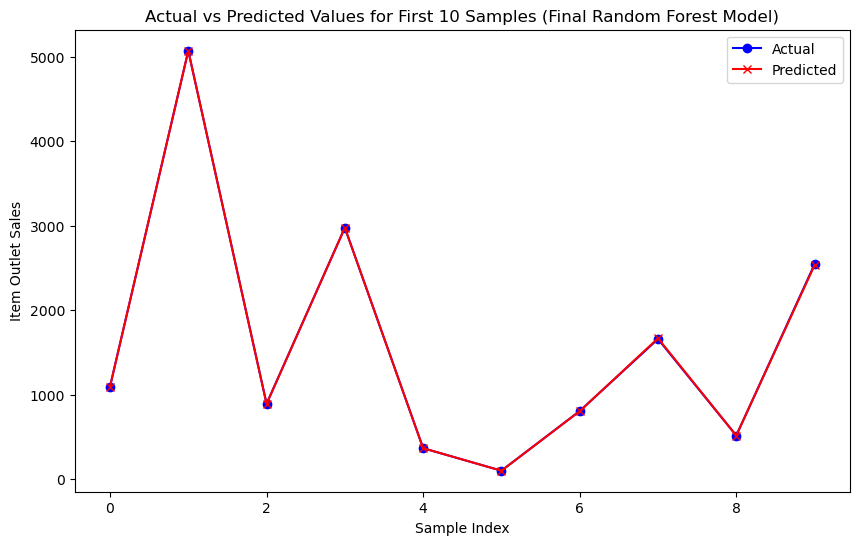

In [46]:
# Getting the first 10 samples from the test set
sample_indices = range(10)
y_actual = y_test.iloc[sample_indices].values
y_pred_best_rf = final_rf_model.predict(x_test.iloc[sample_indices])

# Plotting Actual vs Predicted values for the first 10 samples
plt.figure(figsize=(10, 6))
plt.plot(sample_indices, y_actual, marker='o', color='blue', label='Actual')
plt.plot(sample_indices, y_pred_best_rf, marker='x', color='red', label='Predicted')
plt.xlabel("Sample Index")
plt.ylabel("Item Outlet Sales")
plt.title("Actual vs Predicted Values for First 10 Samples (Final Random Forest Model)")
plt.legend()
plt.show()
